In [1]:
import numpy as np
import cupy as cp
import pandas as pd
import networkx as nx
from numba import cuda
import time
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("F:\\Coding\\Komparawrrr\\Markov_Clustering\\matek_joss\\gugel_scholar.csv")

In [3]:
df.head()

,Author,Co Author,Author_encoded,CoAuthor_encoded
0,"Prof. Alhadi Bustamam, Ph.D",Devvi Sarwinda,0,1
1,"Prof. Alhadi Bustamam, Ph.D",Titin Siswantining,0,21
2,"Prof. Alhadi Bustamam, Ph.D",Prasnurzaki Anki,0,22
3,"Prof. Alhadi Bustamam, Ph.D",Arry Yanuar,0,23
4,"Prof. Alhadi Bustamam, Ph.D",Dian Lestari,0,24


In [4]:
df.shape[0] # number of edges

241

In [6]:
# making the graph
G = nx.from_pandas_edgelist(df, source='Author', target='Co Author')

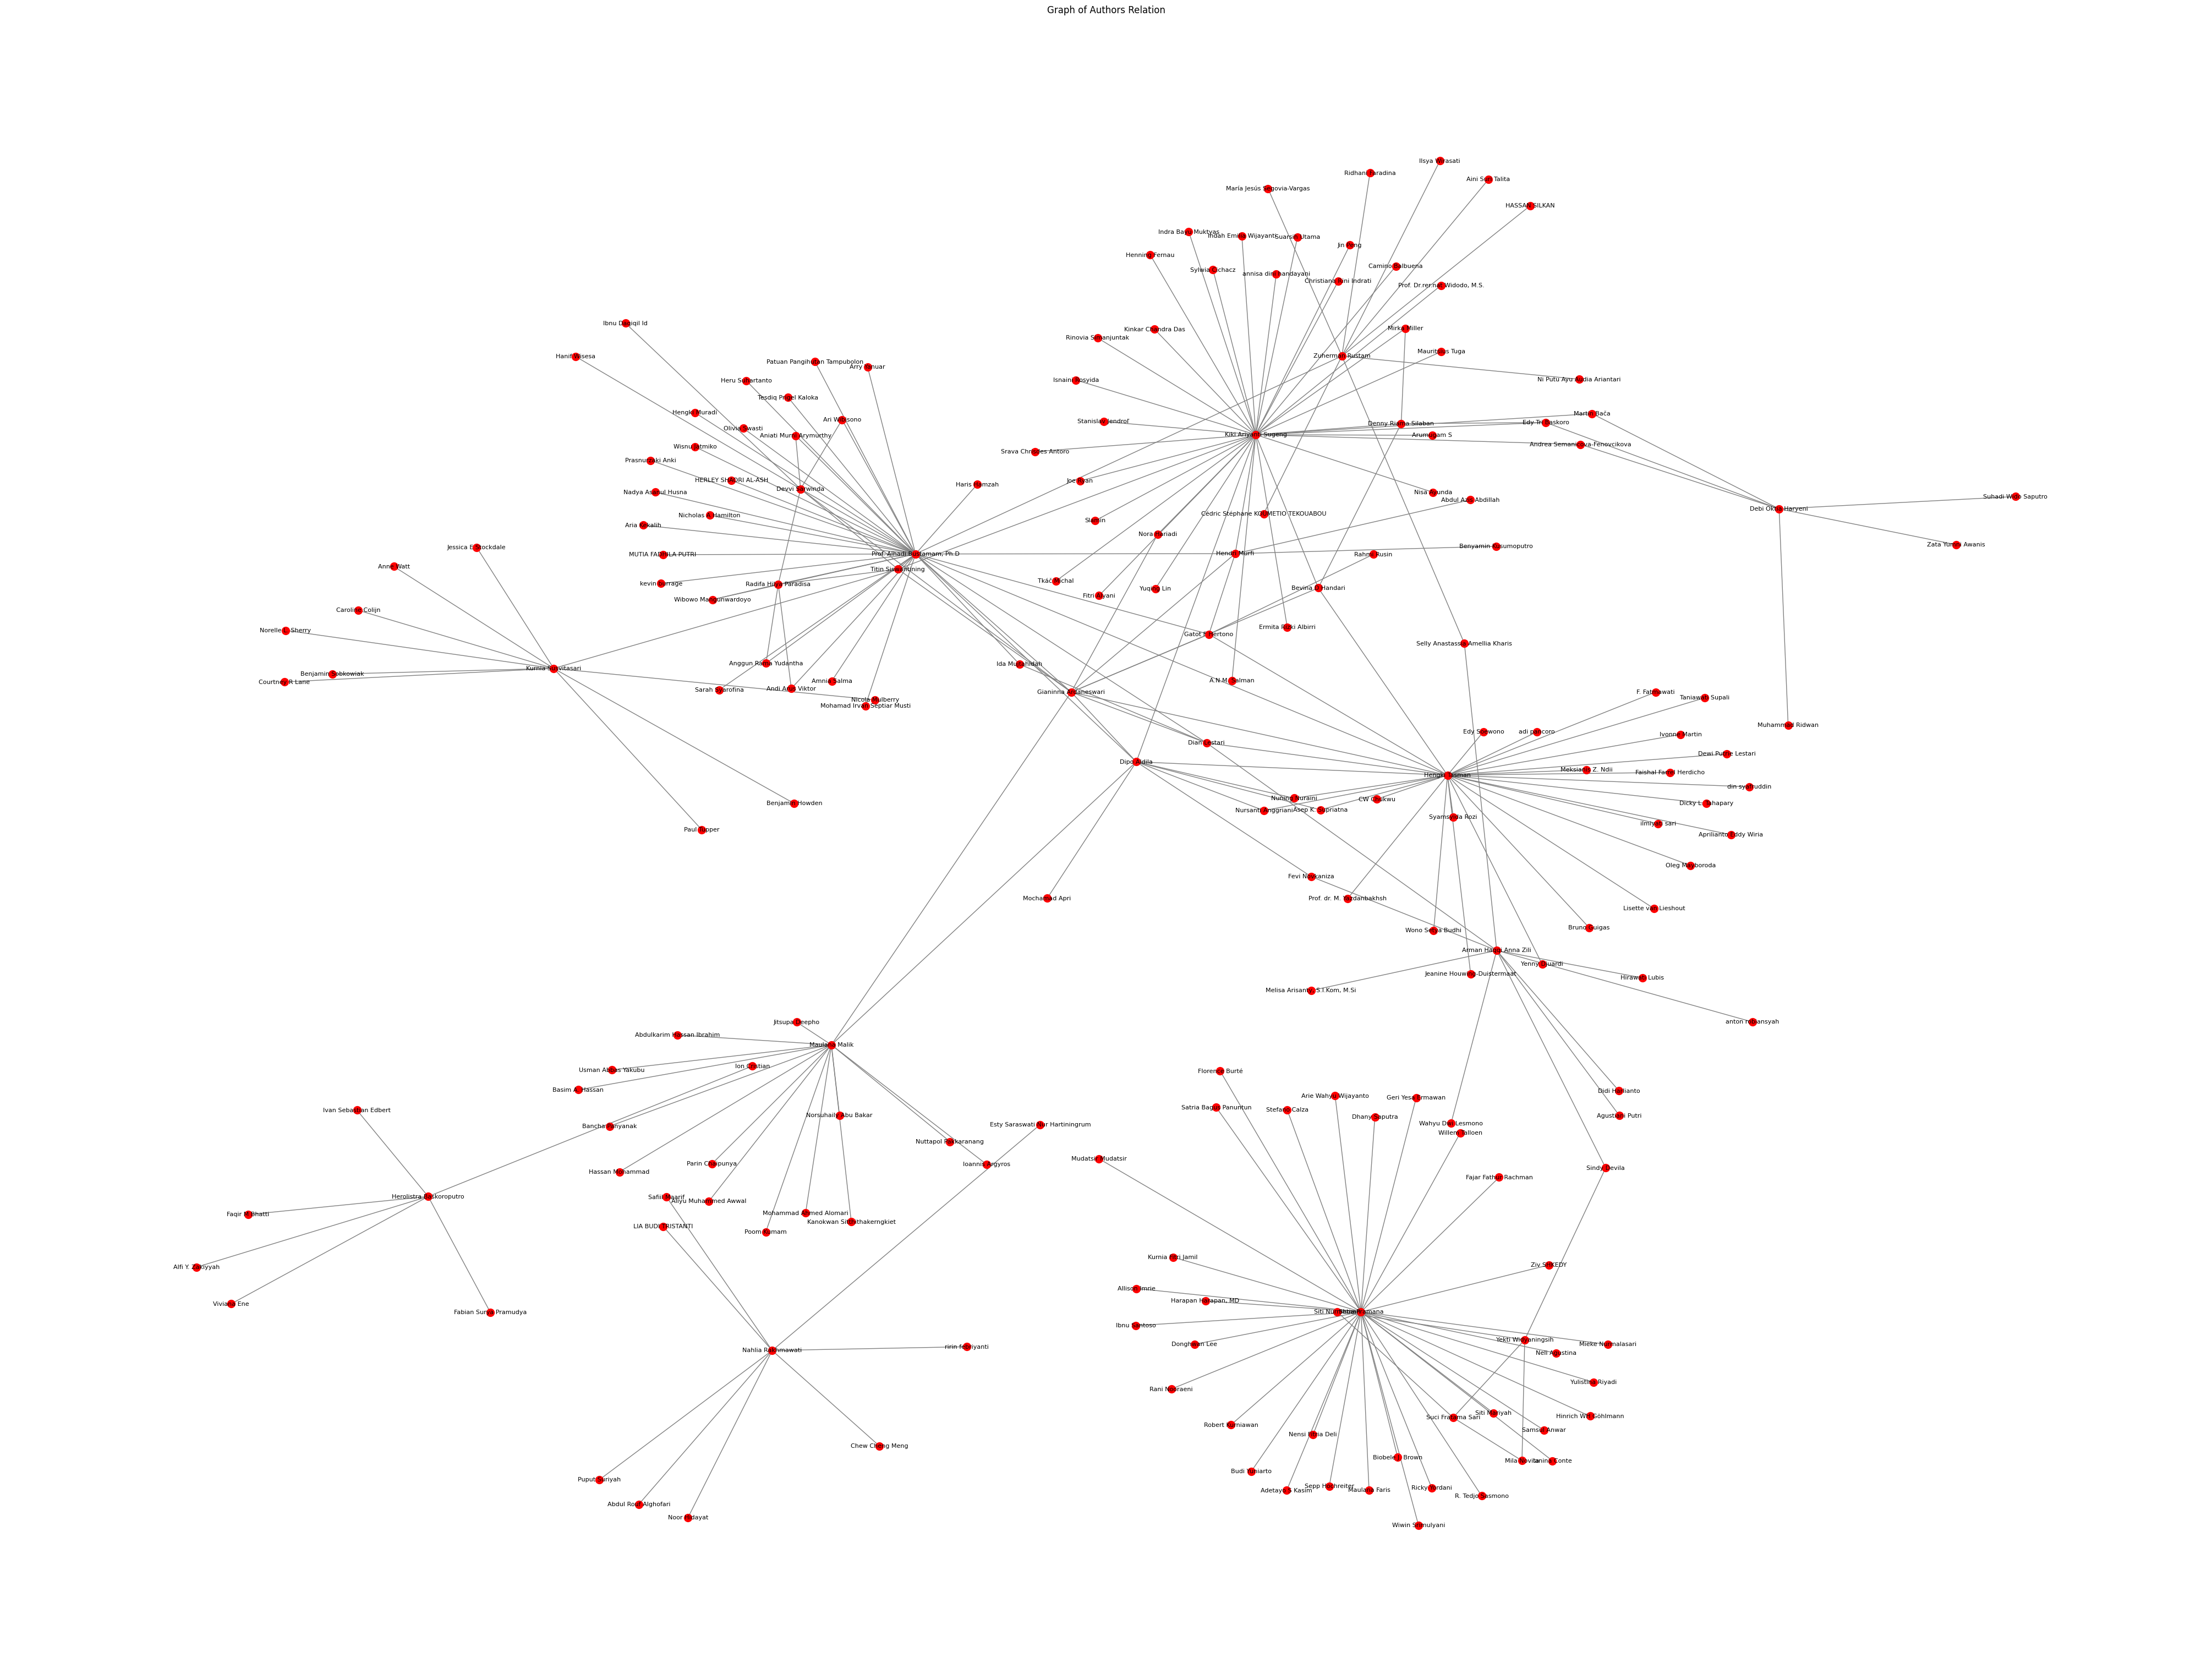

In [12]:
# draw the graph

posi = nx.spring_layout(G, k = 0.2, iterations = 50, seed = 42)

plt.figure(figsize=(40, 30))
nx.draw(
    G,
    pos = posi,
    with_labels=True,
    node_color='red',
    edge_color='gray',
    node_size=100,
    font_size=8
)
plt.title("Graph of Authors Relation")
plt.show()


In [13]:
def print_matrix(matrix):
    for row in matrix:
        print(" ".join(f"{val:.2f}" for val in row))

In [14]:
adj_lastfm = nx.to_numpy_array(G, dtype=np.float32)

print("Numpy Adjacency Matrix:\n", adj_lastfm)

Numpy Adjacency Matrix:
 [[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [15]:
def Normalize(matrix):
    matrix2 = matrix.copy()

    for j in range(len(matrix2[0])):
        temp = 0
        for i in range(len(matrix2)):
            temp += matrix2[i][j]
        for i in range(len(matrix2)):
            matrix2[i][j] = matrix2[i][j] / temp
        
    return matrix2

def Inflate(matrix, r):
    matrix = cp.power(matrix, r)
    col_sums = cp.sum(matrix, axis=0)
    matrix = matrix / col_sums
    return matrix

@cuda.jit
def matmul(A, B, C):
    i, j = cuda.grid(2)
    if i < C.shape[0] and j < C.shape[1]:
        tmp = 0.0
        for k in range(A.shape[1]):
            tmp += A[i, k] * B[k, j]
        C[i, j] = tmp

def powerMatrix(matrix, n, bpg, tpb):
    if n < 1:
        raise ValueError("Pangkat matrix harus >= 1")

    matrix1 = matrix
    matrix2 = cp.zeros_like(matrix)

    for i in range(n - 1):
        matmul[bpg, tpb](matrix1, matrix, matrix2)
        cuda.synchronize()  # penting untuk sinkronisasi kernel
        matrix1 = matrix2.copy()

    return matrix1

def print_matrix(matrix):
    for row in matrix:
        print(" ".join(f"{val:.2f}" for val in row))

def MarkovCluster(matrix_a, e, r, iter):
    matrix = matrix_a

    # Add self-loops
    for i in range(len(matrix)):
        matrix[i][i] = 1

    matrix = Normalize(matrix)

    print("Normalized Matrix:\n", matrix)

    matrix = cp.asarray(matrix)

    # Setup CUDA kernel execution config
    threadsperblock = (16, 16)
    blockspergrid_x = int(np.ceil(matrix.shape[0] / threadsperblock[0]))
    blockspergrid_y = int(np.ceil(matrix.shape[1] / threadsperblock[1]))
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    iterate = iter
    tol = 1e-7
    ptr = 0
    converged = False

    while ptr < iterate and not converged:
        prev_matrix = matrix.copy()

        matrix = powerMatrix(matrix, e, bpg=blockspergrid, tpb=threadsperblock)
        matrix = Inflate(matrix, r)

        # Cek konvergensi
        diff = cp.abs(matrix - prev_matrix)
        max_diff = cp.max(diff)
        if max_diff < tol:
            converged = True

        ptr += 1

    matrix = matrix.get()
    return matrix

In [ ]:

e_1 = 2
r_1 = 2
start = time.time()
MarkovMatrix = MarkovCluster(matrix_a=adj_lastfm, e = e_1, r = r_1, iter = 20)
end = time.time()

Normalized Matrix:
 [[0.02857143 0.11111111 0.14285715 ... 0.         0.         0.        ]
 [0.02857143 0.11111111 0.14285715 ... 0.         0.         0.        ]
 [0.02857143 0.11111111 0.14285715 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.5        0.         0.        ]
 [0.         0.         0.         ... 0.         0.5        0.        ]
 [0.         0.         0.         ... 0.         0.         0.5       ]]
Normalized Matrix:
 [[0.02857143 0.11111111 0.14285715 ... 0.         0.         0.        ]
 [0.02857143 0.11111111 0.14285715 ... 0.         0.         0.        ]
 [0.02857143 0.11111111 0.14285715 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.5        0.         0.        ]
 [0.         0.         0.         ... 0.         0.5        0.        ]
 [0.         0.         0.         ... 0.         0.         0.5       ]]
Normalized Matrix:
 [[0.02857143 0.11111111 0.14285715 ... 0.         0.

In [23]:
print(f"waktu yang dibutuhkna = {end - start} detik")

waktu yang dibutuhkna = 2.331007719039917 detik


In [24]:
print(MarkovMatrix)

[[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [18]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# === 1. MCL Matrix Sample ===
matriks_mcl = MarkovMatrix[:1000, :1000]

# === 2. Extract Clusters ===
def extract_clusters(mtx, threshold=0.01):
    binary = (mtx > threshold).astype(int)
    clusters = []
    visited = set()
    for i in range(binary.shape[0]):
        if i in visited:
            continue
        cluster = set(np.nonzero(binary[i])[0])
        if cluster:
            clusters.append(tuple(cluster))
            visited.update(cluster)
    return clusters

clusters = extract_clusters(matriks_mcl)

# === 3. Create Graph ===
adj_matrix = (matriks_mcl > 0.01).astype(int)
G = nx.from_numpy_array(adj_matrix)

# Assign cluster IDs
cluster_dict = {}
for cluster_id, cluster in enumerate(clusters):
    for node in cluster:
        cluster_dict[node] = cluster_id

# === 4. Draw and Save PNG ===
pos = nx.spring_layout(G, seed=42)
node_colors = [cluster_dict.get(node, -1) for node in G.nodes]

plt.figure(figsize=(30, 20))
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5)
nx.draw_networkx_nodes(
    G, pos,
    node_color=node_colors,
    cmap=plt.cm.Set3,
    node_size=250,
    edgecolors='gray'
)
# nx.draw_networkx_labels(G, pos)

plt.title("Visualisasi Cluster dari MCL")
plt.axis('off')
plt.tight_layout()

# ✅ Save to PNG
plt.savefig("mcl_graph.png", dpi=300)
plt.close()

print("✅ Gambar disimpan sebagai mcl_graph.png")


✅ Gambar disimpan sebagai mcl_graph.png


In [56]:
from PIL import Image
Image.open("mcl_graph.png").show()


In [19]:
def get_clusters_from_square_matrix(mcl_matrix):
    """
    mcl_matrix: square numpy array (n_nodes x n_nodes), hasil dari MCL
                dengan 1s menunjukkan koneksi antar node dalam cluster
    return: list of clusters, each cluster is a list of node indices
    """
    # Buat graph dari adjacency matrix
    G = nx.from_numpy_array(mcl_matrix)

    # Ambil connected components (cluster)
    clusters = [list(component) for component in nx.connected_components(G)]

    return clusters

clusters = get_clusters_from_square_matrix(MarkovMatrix)

for i, cluster in enumerate(clusters):
    print(f"Cluster {i+1}: {cluster}")

Cluster 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 31, 32, 33, 34, 119, 120, 121]
Cluster 2: [9, 18, 35, 36, 37, 39, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
Cluster 3: [192, 193, 194, 195, 196, 197, 38, 159, 160, 155, 115, 153, 154, 27, 156, 157, 158, 191]
Cluster 4: [43, 44, 30]
Cluster 5: [129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 40, 42, 122, 123, 125, 126, 127]
Cluster 6: [100, 101, 102, 103, 104, 41, 105, 106, 107, 108, 109, 110, 111, 112, 113]
Cluster 7: [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78]
Cluster 8: [114, 116, 117, 118]
Cluster 9: [128, 161, 162, 163, 164, 124]
Cluster 10: [165, 166, 167, 168, 169, 170, 171]
Cluster 11: [172, 173, 174, 175, 176, 177, 178, 179, 180, 181]
Cluster 12: [182, 183, 184, 185